In [9]:
# downloading our data
# code copied from my other 
# VAE repo.
import torchvision

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.ToTensor()
])

train_data = torchvision.datasets.Imagenette(
    'imagenette',
    split = 'train',
    download=False,
    transform=transform
)

In [7]:

transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32,32]),
    torchvision.transforms.ToTensor()
])

train_data2 = torchvision.datasets.CIFAR10(
    'cifar_10',
    train=True,
    download=False,
    transform=transform2
)
print(len(train_data2))

50000


torch.Size([3, 256, 256])


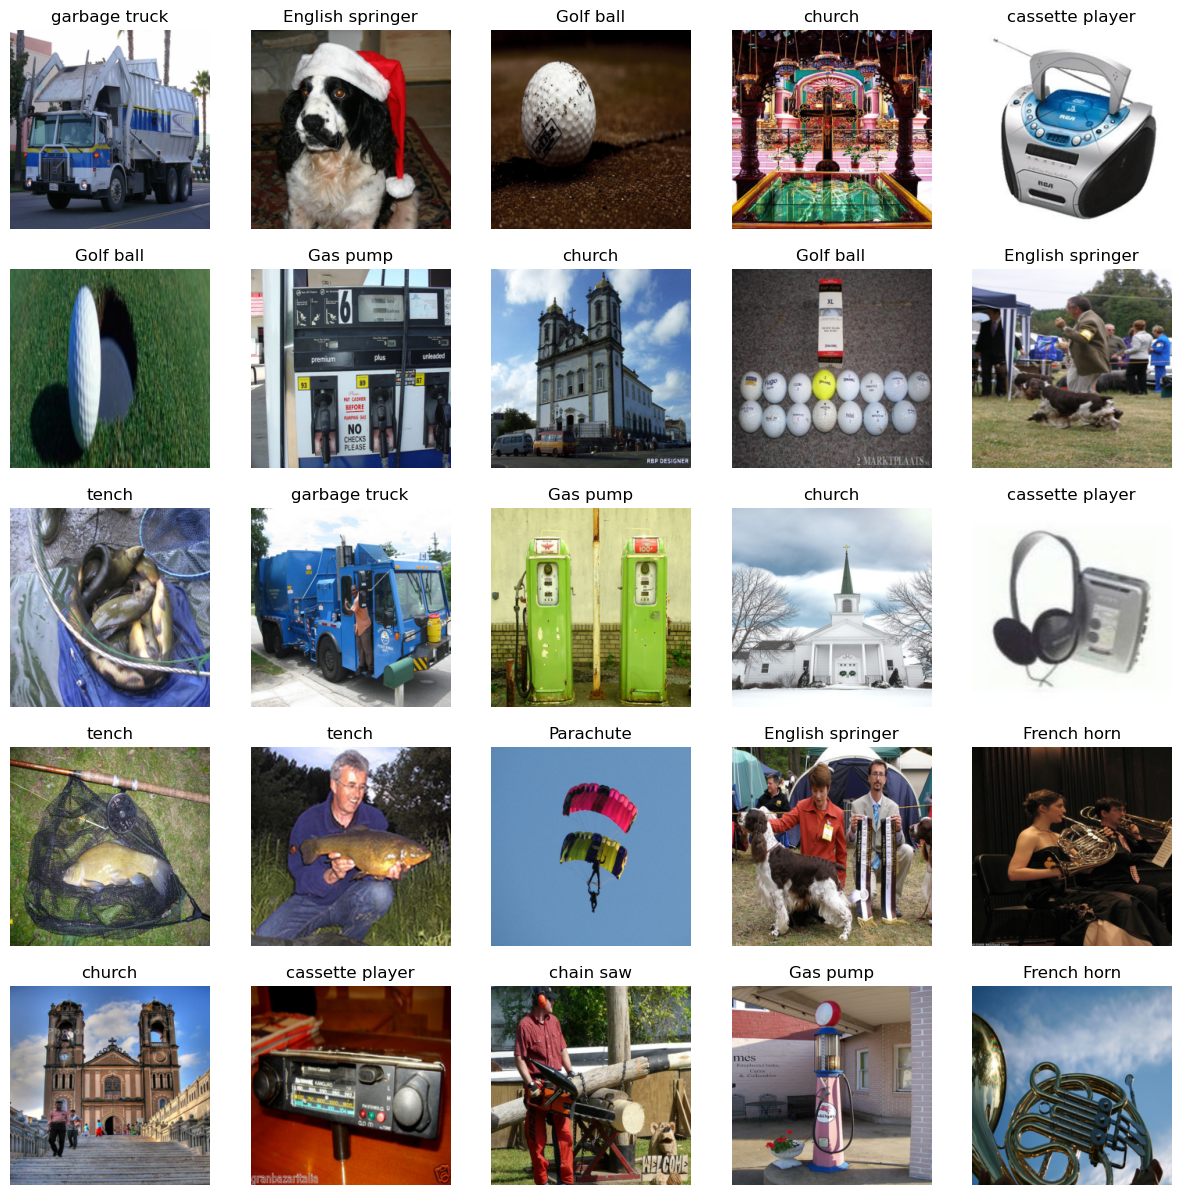

In [10]:
# not using custom dataset, bc don't need latents.
import matplotlib.pyplot as plt
import torch
label_map = {
    0: 'tench',
    1: 'English springer',
    2: 'cassette player',
    3: 'chain saw',
    4: 'church',
    5: 'French horn',
    6: 'garbage truck',
    7: 'Gas pump',
    8: 'Golf ball',
    9: 'Parachute'
}
print(train_data[0][0].shape)

fig,axes = plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(25):
    ind = torch.randint(0,len(train_data),size=(1,)).item()
    axes[i//5][i%5].imshow(train_data[ind][0].permute(1,2,0))
    axes[i//5][i%5].set_title(label_map[train_data[ind][1]])
    axes[i//5][i%5].axis("off")

torch.Size([3, 32, 32])


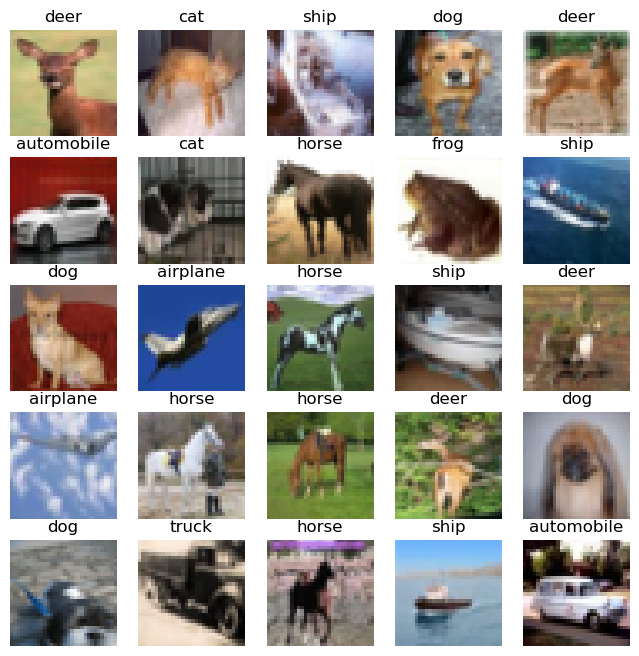

In [5]:
map_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
print(train_data2[0][0].shape)

fig,axes = plt.subplots(5,5)
fig.set_size_inches(8,8)
for i in range(25):
    ind = torch.randint(0,len(train_data2),size=(1,)).item()
    axes[i//5][i%5].imshow(train_data2[ind][0].permute(1,2,0))
    axes[i//5][i%5].set_title(map_labels[train_data2[ind][1]])
    axes[i//5][i%5].axis("off")